In [1]:
# =========================================================
# step0. 載入必要套件
# =========================================================
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
# =========================================================
# step1. 定義資料讀取與前處理
# =========================================================
test_folder = "./ballet_test/"
pose_data_dict = {}

def parse_point(s):
    s = s.strip("()")
    result = []
    for p in s.split(","):
        try:
            result.append(float(p.strip(" '")))
        except ValueError:
            result.append(0.0)  # 或 np.nan
    return result

def csv_to_pose_array(csv_path):
    df = pd.read_csv(csv_path)
    pose_cols = [c for c in df.columns if c != "frame"]
    poses = []
    for i, row in df.iterrows():
        pose = []
        for c in pose_cols:
            pose += parse_point(row[c])
        poses.append(pose)
    return np.array(poses)

all_poses_list = []
file_pose_map = {}
for file_name in os.listdir(test_folder):
    if file_name.endswith(".csv"):
        file_path = os.path.join(test_folder, file_name)
        poses = csv_to_pose_array(file_path)
        all_poses_list.append(poses)
        file_pose_map[file_name] = poses

all_poses_combined = np.concatenate(all_poses_list, axis=0)
scaler = StandardScaler()
all_poses_scaled = scaler.fit_transform(all_poses_combined)

In [3]:
# =========================================================
# step2. 定義 VQ-VAE 模型結構
# =========================================================
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)
    def forward(self, x):
        distances = (
            torch.sum(x**2, dim=1, keepdim=True) +
            torch.sum(self.embedding.weight**2, dim=1) -
            2 * torch.matmul(x, self.embedding.weight.t())
        )
        encoding_indices = torch.argmin(distances, dim=1)
        quantized = self.embedding(encoding_indices)
        return quantized, encoding_indices

class VQVAE(nn.Module):
    def __init__(self, input_dim=99, hidden_dim=128, latent_dim=32, num_embeddings=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.vq = VectorQuantizer(num_embeddings, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        z_q, indices = self.vq(z)
        x_recon = self.decoder(z_q)
        return x_recon, indices, z, z_q

In [4]:
# =========================================================
# step3. 載入模型
# =========================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VQVAE().to(device)
model.load_state_dict(torch.load("vqvae_ballet.pth", map_location=device))
model.eval()
print("✅ 模型載入完成")

✅ 模型載入完成


C:\Users\AW'z\AppData\Local\Temp\ipykernel_24192\4282522863.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("vqvae_ballet.pth", map_loca

In [5]:
# =========================================================
# step4. 將資料轉成 latent vector
# =========================================================
all_poses_tensor = torch.tensor(all_poses_scaled, dtype=torch.float32).to(device)
with torch.no_grad():
    _, _, _, z_q = model(all_poses_tensor)
latent_vectors = z_q.cpu().numpy()

In [6]:
# =========================================================
# step5. KMeans 分群
# =========================================================
NUM_ACTIONS = 6  # 假設 6 種基本動作
kmeans = KMeans(n_clusters=NUM_ACTIONS, random_state=42)
action_labels_all = kmeans.fit_predict(latent_vectors)

# Silhouette score 評估
score = silhouette_score(latent_vectors, action_labels_all)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.9981


In [7]:
# =========================================================
# step6. 將每個檔案的動作編號分離
# =========================================================
start_idx = 0
for file_name, poses in file_pose_map.items():
    n_frames = poses.shape[0]
    action_labels_file = action_labels_all[start_idx:start_idx + n_frames]
    pose_data_dict[file_name] = action_labels_file.tolist()
    start_idx += n_frames

In [8]:
# =========================================================
# step7. 存成 JSON
# =========================================================
json_path = "ballet_test.json"
with open(json_path, "w") as f:
    json.dump(pose_data_dict, f, indent=4, ensure_ascii=False)

print(f"💾 JSON 檔案已存成 {json_path}")

💾 JSON 檔案已存成 ballet_test.json


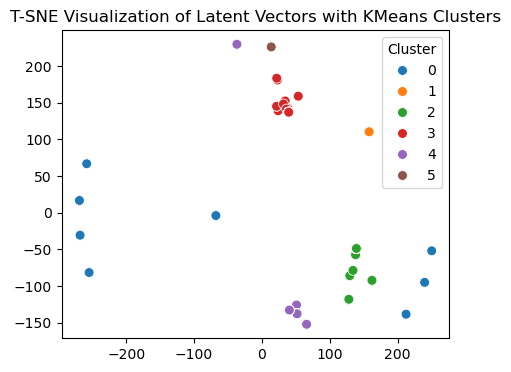

In [9]:
# -----------------------------
# step8. TSNE 視覺化
# -----------------------------
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

plt.figure(figsize=(5, 4))
sns.scatterplot(x=latent_2d[:,0], y=latent_2d[:,1], hue=action_labels_all, palette="tab10", s=50)
plt.title("T-SNE Visualization of Latent Vectors with KMeans Clusters")
plt.legend(title="Cluster")
plt.show()

In [10]:
# -----------------------------
# 手動對應 cluster -> 芭蕾舞基本動作
# -----------------------------
cluster_action_map = {
    0: "Plie",
    1: "Tendu",
    2: "Relevé",
    3: "Arabesque",
    4: "Pirouette",
    5: "Jeté"
}

# 印出對照表
print("Cluster 對應的芭蕾舞基本動作：")
for cluster, action in cluster_action_map.items():
    print(f"Cluster {cluster}: {action}")

Cluster 對應的芭蕾舞基本動作：
Cluster 0: Plie
Cluster 1: Tendu
Cluster 2: Relevé
Cluster 3: Arabesque
Cluster 4: Pirouette
Cluster 5: Jeté


In [11]:
# -----------------------------
# step9. 檢查不同檔案群編號一致性
# -----------------------------
for i, file_name in enumerate(pose_data_dict.keys()):
    print(f"{file_name} clusters range: {set(pose_data_dict[file_name])}")

Ballet_35.csv clusters range: {0, 2, 3}
Ballet_36.csv clusters range: {0, 1, 2, 3, 4, 5}
Ballet_37.csv clusters range: {0, 1, 2, 3, 4, 5}
Ballet_38.csv clusters range: {0, 2}
Ballet_39.csv clusters range: {0, 1, 2, 3, 4}
Ballet_40.csv clusters range: {0, 1, 2, 3, 4}
Ballet_41.csv clusters range: {0, 1, 2, 3, 4, 5}
Ballet_42.csv clusters range: {0}
Ballet_43.csv clusters range: {0, 1, 2, 3, 4, 5}
Ballet_44.csv clusters range: {0}
Ballet_45.csv clusters range: {0, 1, 2, 3, 4, 5}
Ballet_46.csv clusters range: {0}
Ballet_47.csv clusters range: {0, 1, 2, 3, 4, 5}
Ballet_48.csv clusters range: {0, 1, 2, 3}


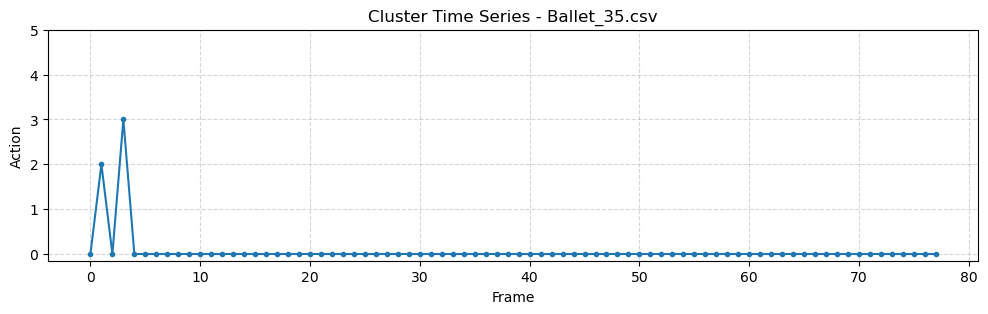

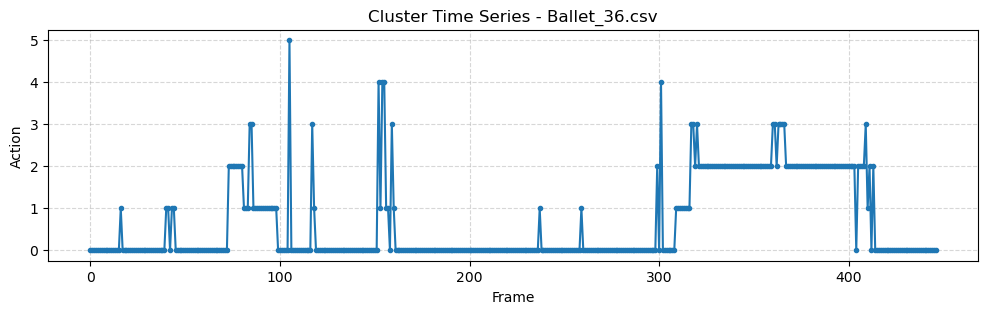

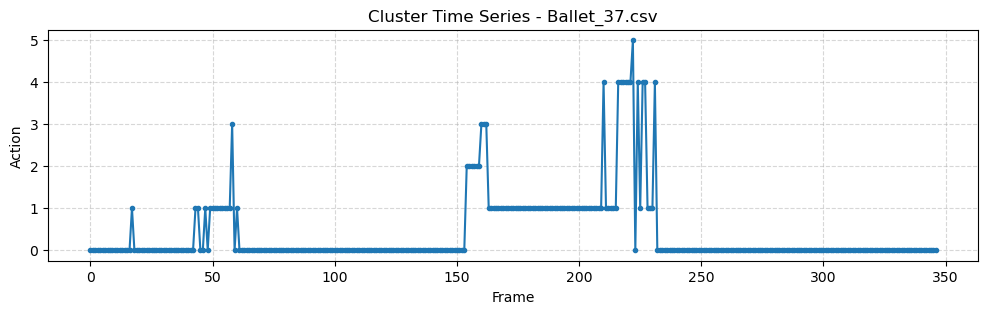

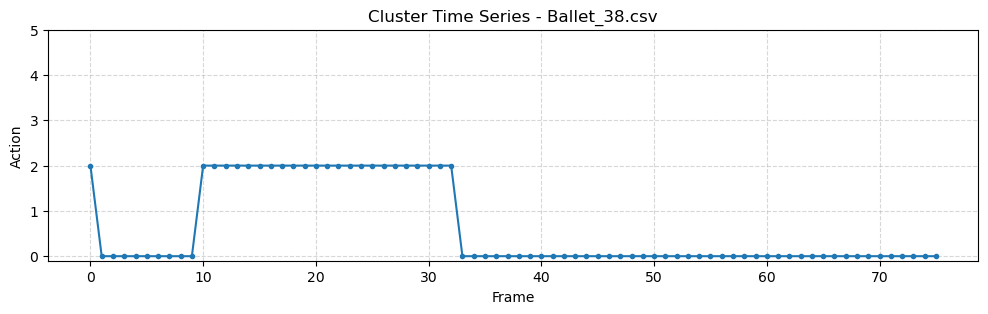

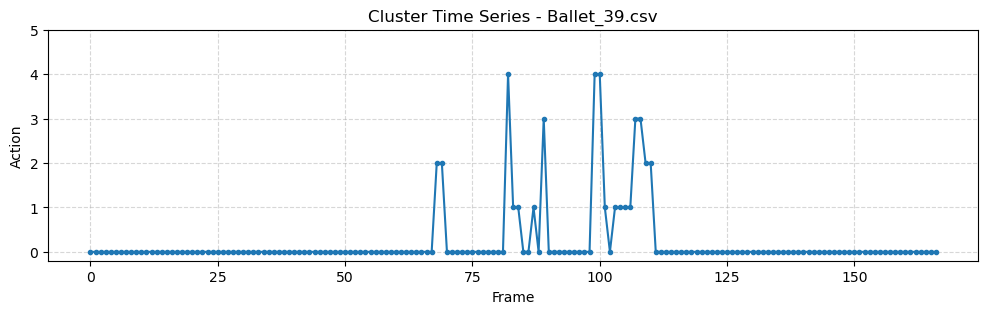

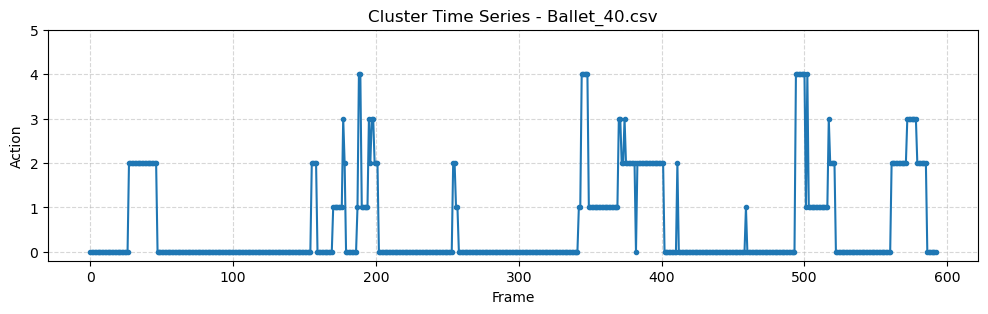

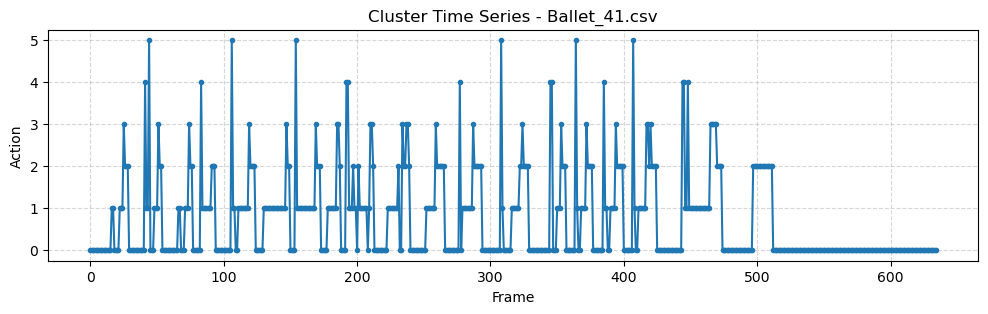

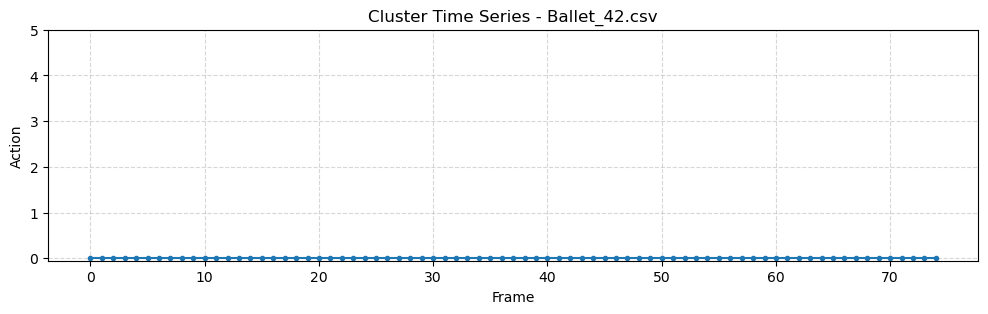

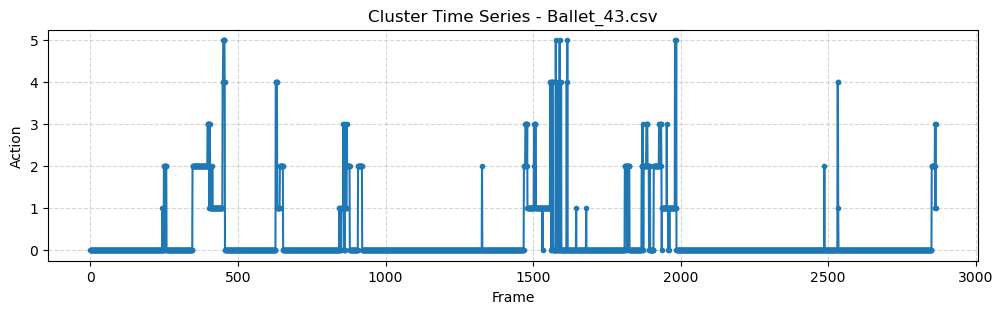

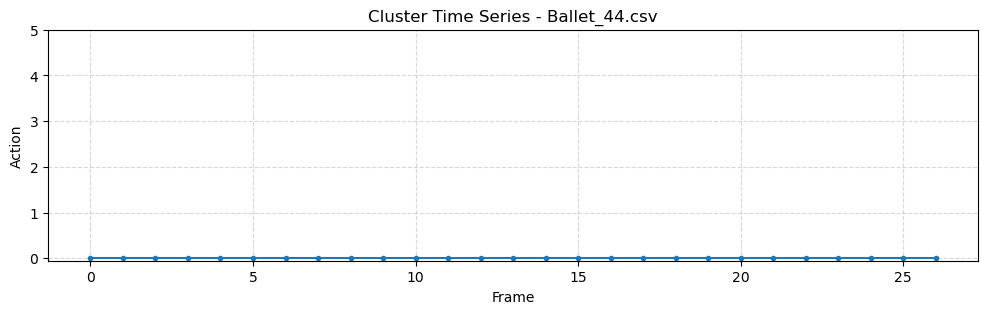

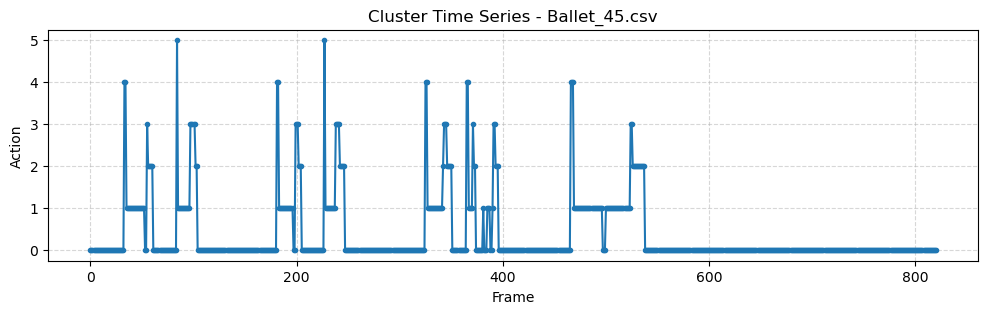

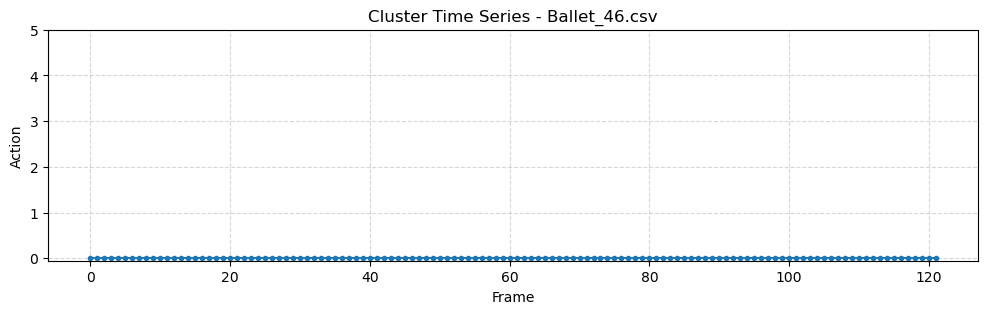

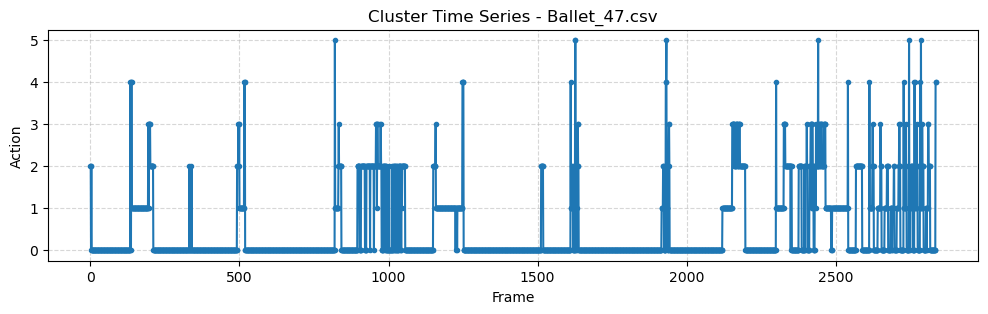

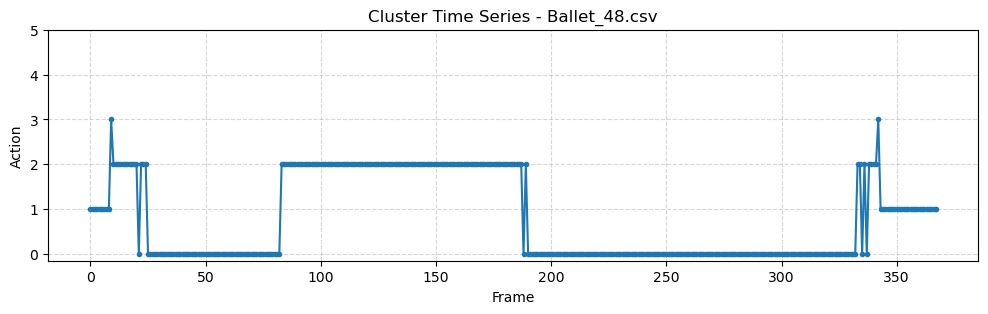

In [12]:
# -----------------------------
# step10. 繪製每個檔案的分群時間序列圖
# -----------------------------
for file_name, action_labels in pose_data_dict.items():
    plt.figure(figsize=(12, 3))
    plt.plot(action_labels, marker='o', linestyle='-', markersize=3)
    plt.title(f"Cluster Time Series - {file_name}")
    plt.xlabel("Frame")
    plt.ylabel("Action")
    plt.yticks(range(NUM_ACTIONS))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [13]:
# -----------------------------
# step11. 將每個檔案的連續動作壓縮成 [動作編號, 起始幀, 結束幀]
# -----------------------------
compressed_pose_data = {}

for file_name, action_labels in pose_data_dict.items():
    compressed = []
    if len(action_labels) == 0:
        compressed_pose_data[file_name] = compressed
        continue
    
    start_frame = 0
    current_label = action_labels[0]

    for i in range(1, len(action_labels)):
        if action_labels[i] != current_label:
            # 當前動作結束，加入結果
            compressed.append([current_label, start_frame, i - 1])
            current_label = action_labels[i]
            start_frame = i
    # 加入最後一段
    compressed.append([current_label, start_frame, len(action_labels) - 1])
    
    compressed_pose_data[file_name] = compressed

# -----------------------------
# 存成 JSON
# -----------------------------
compressed_json_path = "ballet_test_actions_compressed.json"
with open(compressed_json_path, "w") as f:
    json.dump(compressed_pose_data, f, indent=4, ensure_ascii=False)

print(f"💾 壓縮後 JSON 已存成 {compressed_json_path}")

💾 壓縮後 JSON 已存成 ballet_test_actions_compressed.json


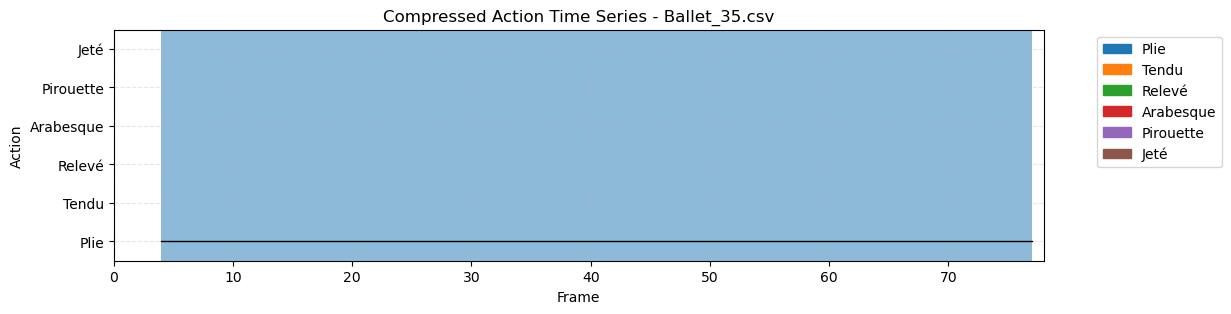

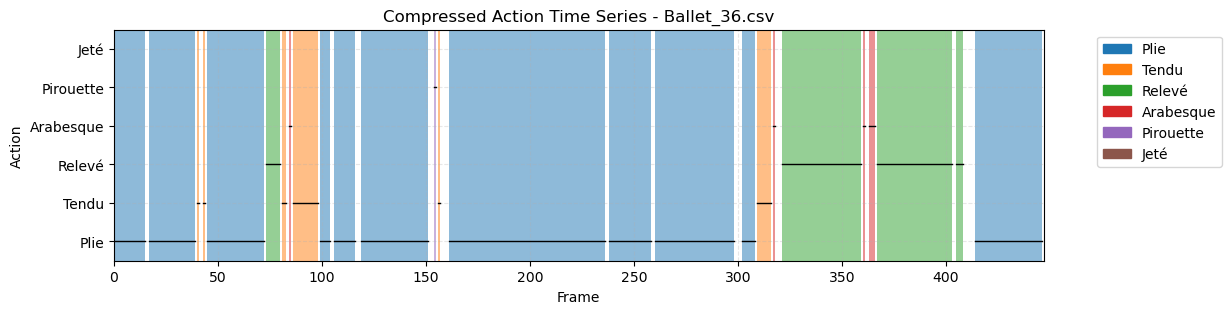

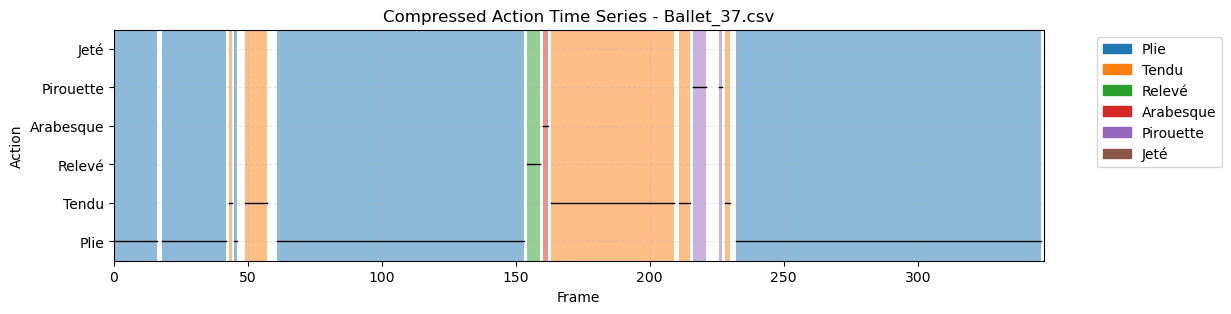

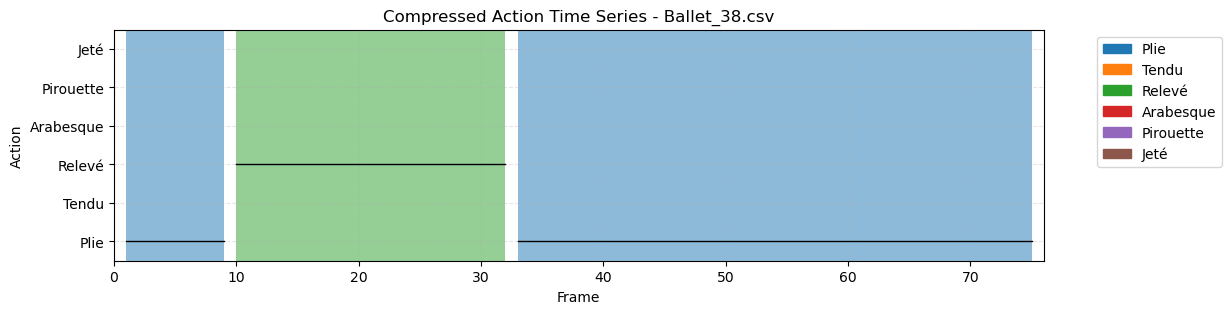

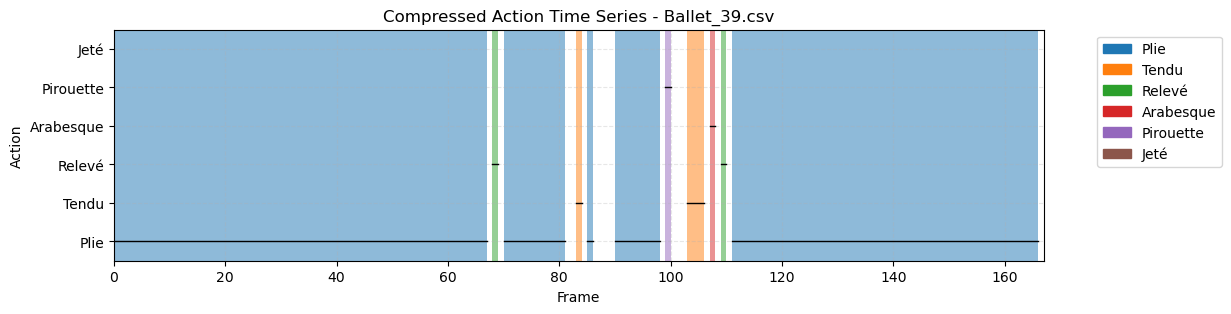

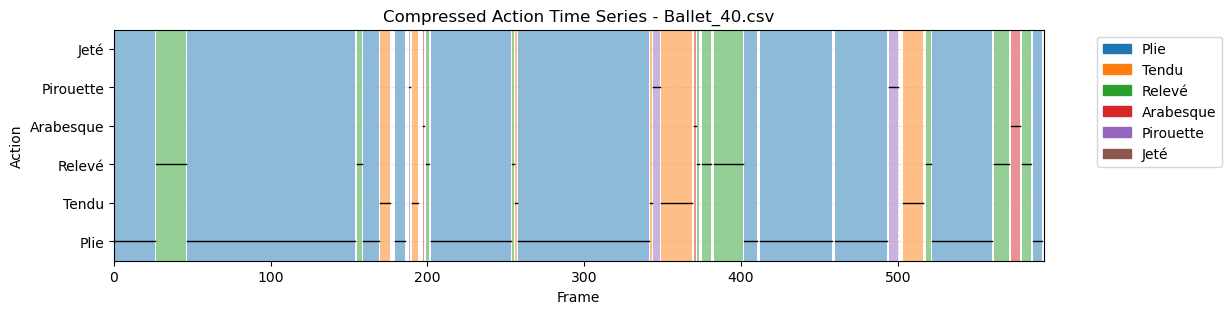

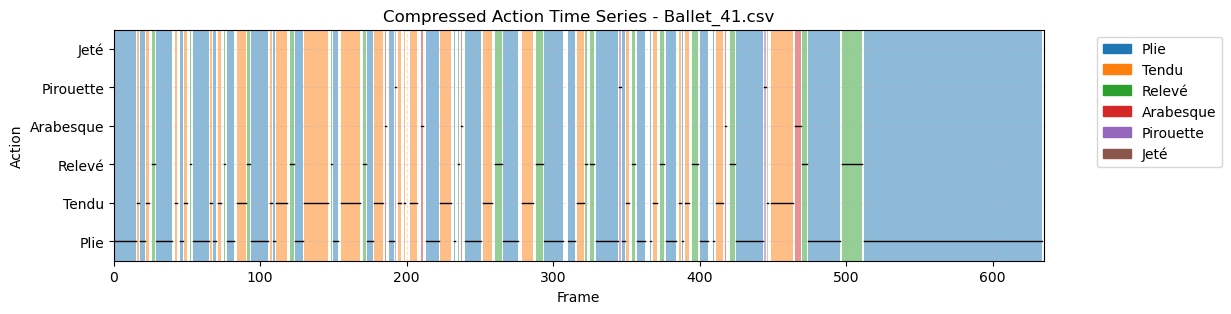

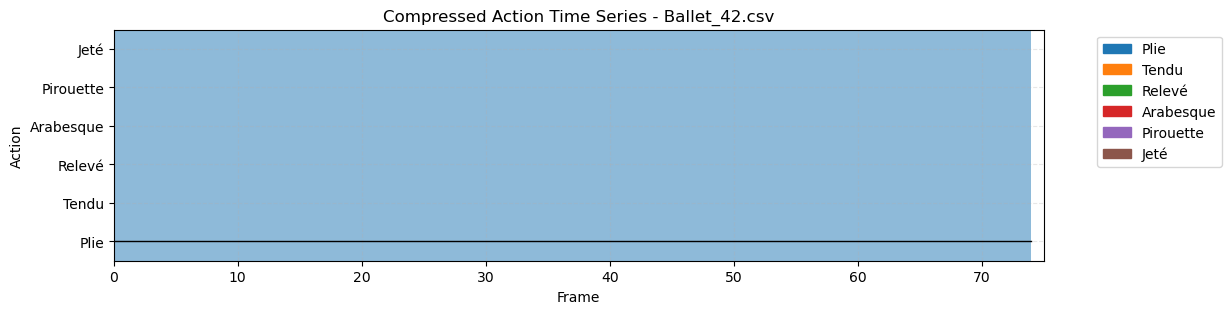

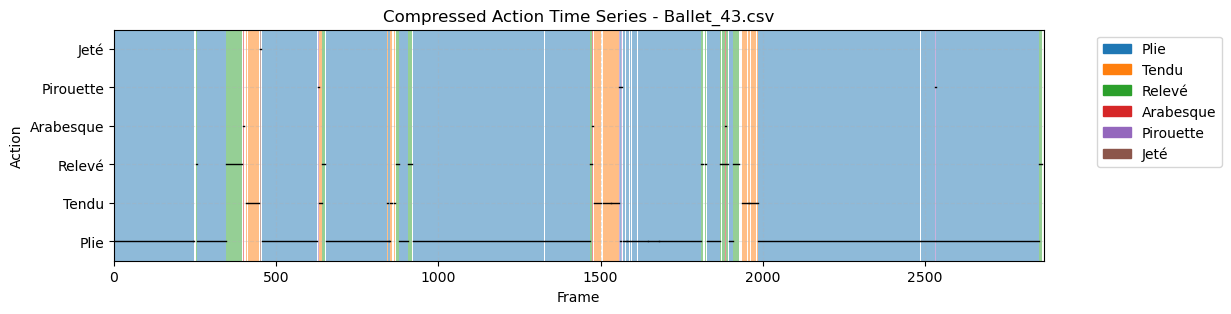

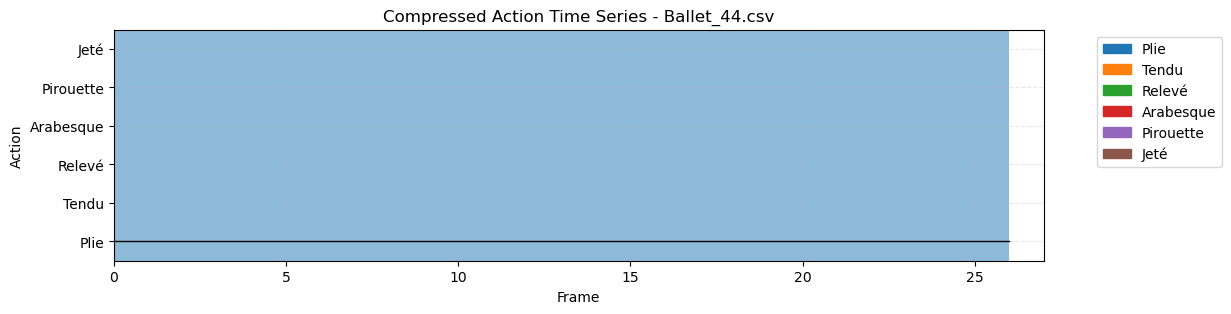

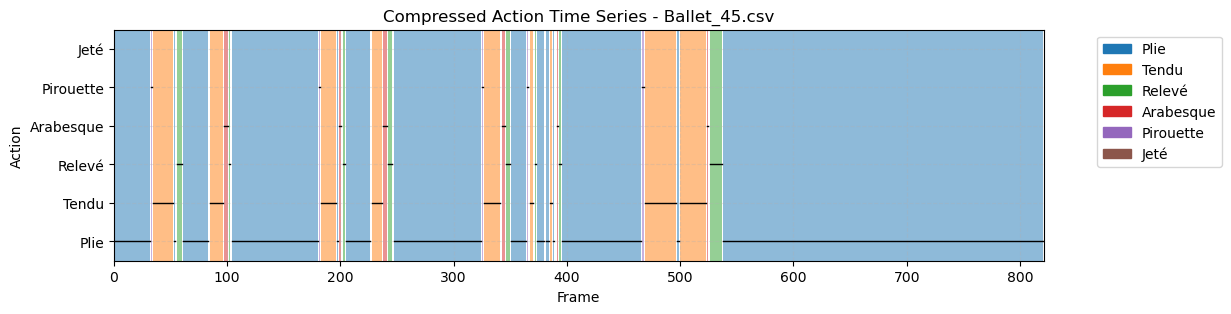

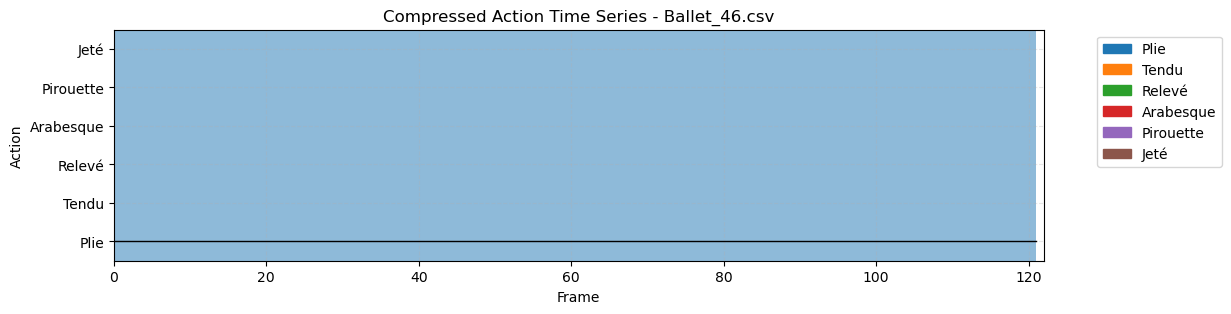

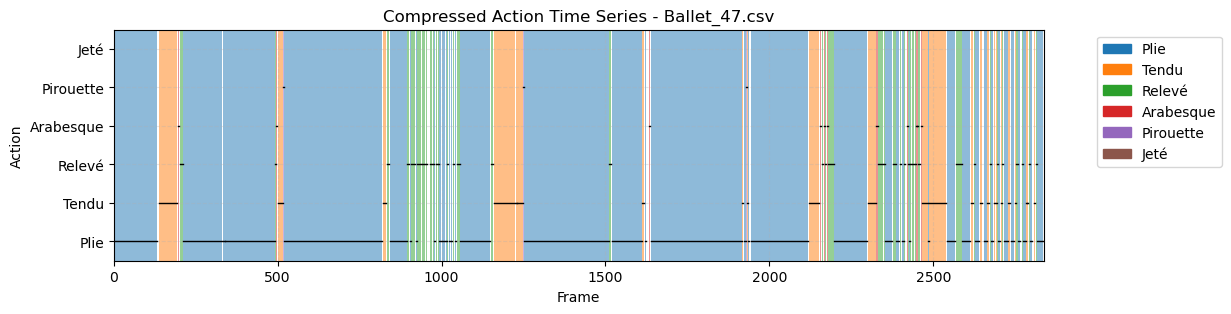

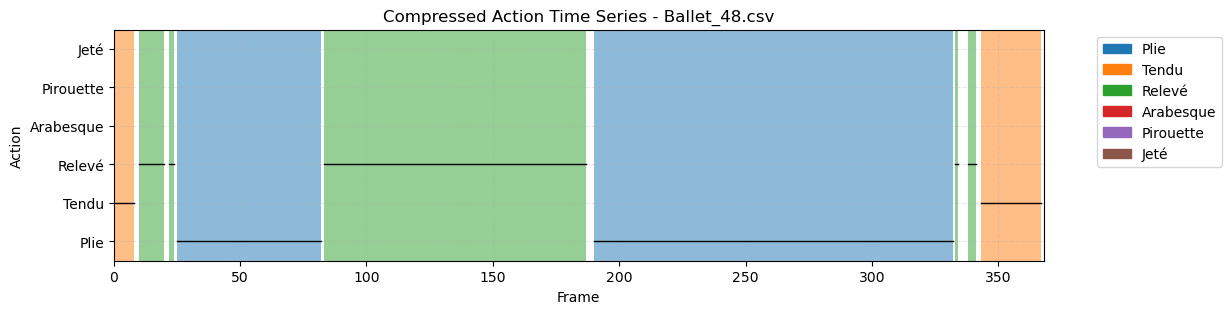

In [14]:
# -----------------------------
# step12. 使用顏色區塊繪製每個檔案的壓縮動作時間序列圖
# -----------------------------
import matplotlib.patches as mpatches

for file_name, compressed in compressed_pose_data.items():
    plt.figure(figsize=(12, 3))
    ax = plt.gca()
    
    # 顏色對應每個動作群
    colors = plt.cm.tab10.colors  # 最多 10 種顏色，對應動作編號
    for segment in compressed:
        label, start, end = segment
        ax.axvspan(start, end, facecolor=colors[label % 10], alpha=0.5)
        ax.plot(range(start, end+1), [label]*(end-start+1), color='black', linewidth=1)
    
    ax.set_xlim(0, sum([seg[2]-seg[1]+1 for seg in compressed]))
    ax.set_ylim(-0.5, NUM_ACTIONS-0.5)
    ax.set_yticks(range(NUM_ACTIONS))
    ax.set_yticklabels([cluster_action_map[i] for i in range(NUM_ACTIONS)])  # Y軸顯示動作名稱
    ax.set_xlabel("Frame")
    ax.set_ylabel("Action")
    ax.set_title(f"Compressed Action Time Series - {file_name}")
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # 顯示圖例（使用動作名稱）
    patches = [mpatches.Patch(color=colors[i % 10], label=cluster_action_map[i]) for i in range(NUM_ACTIONS)]
    ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()

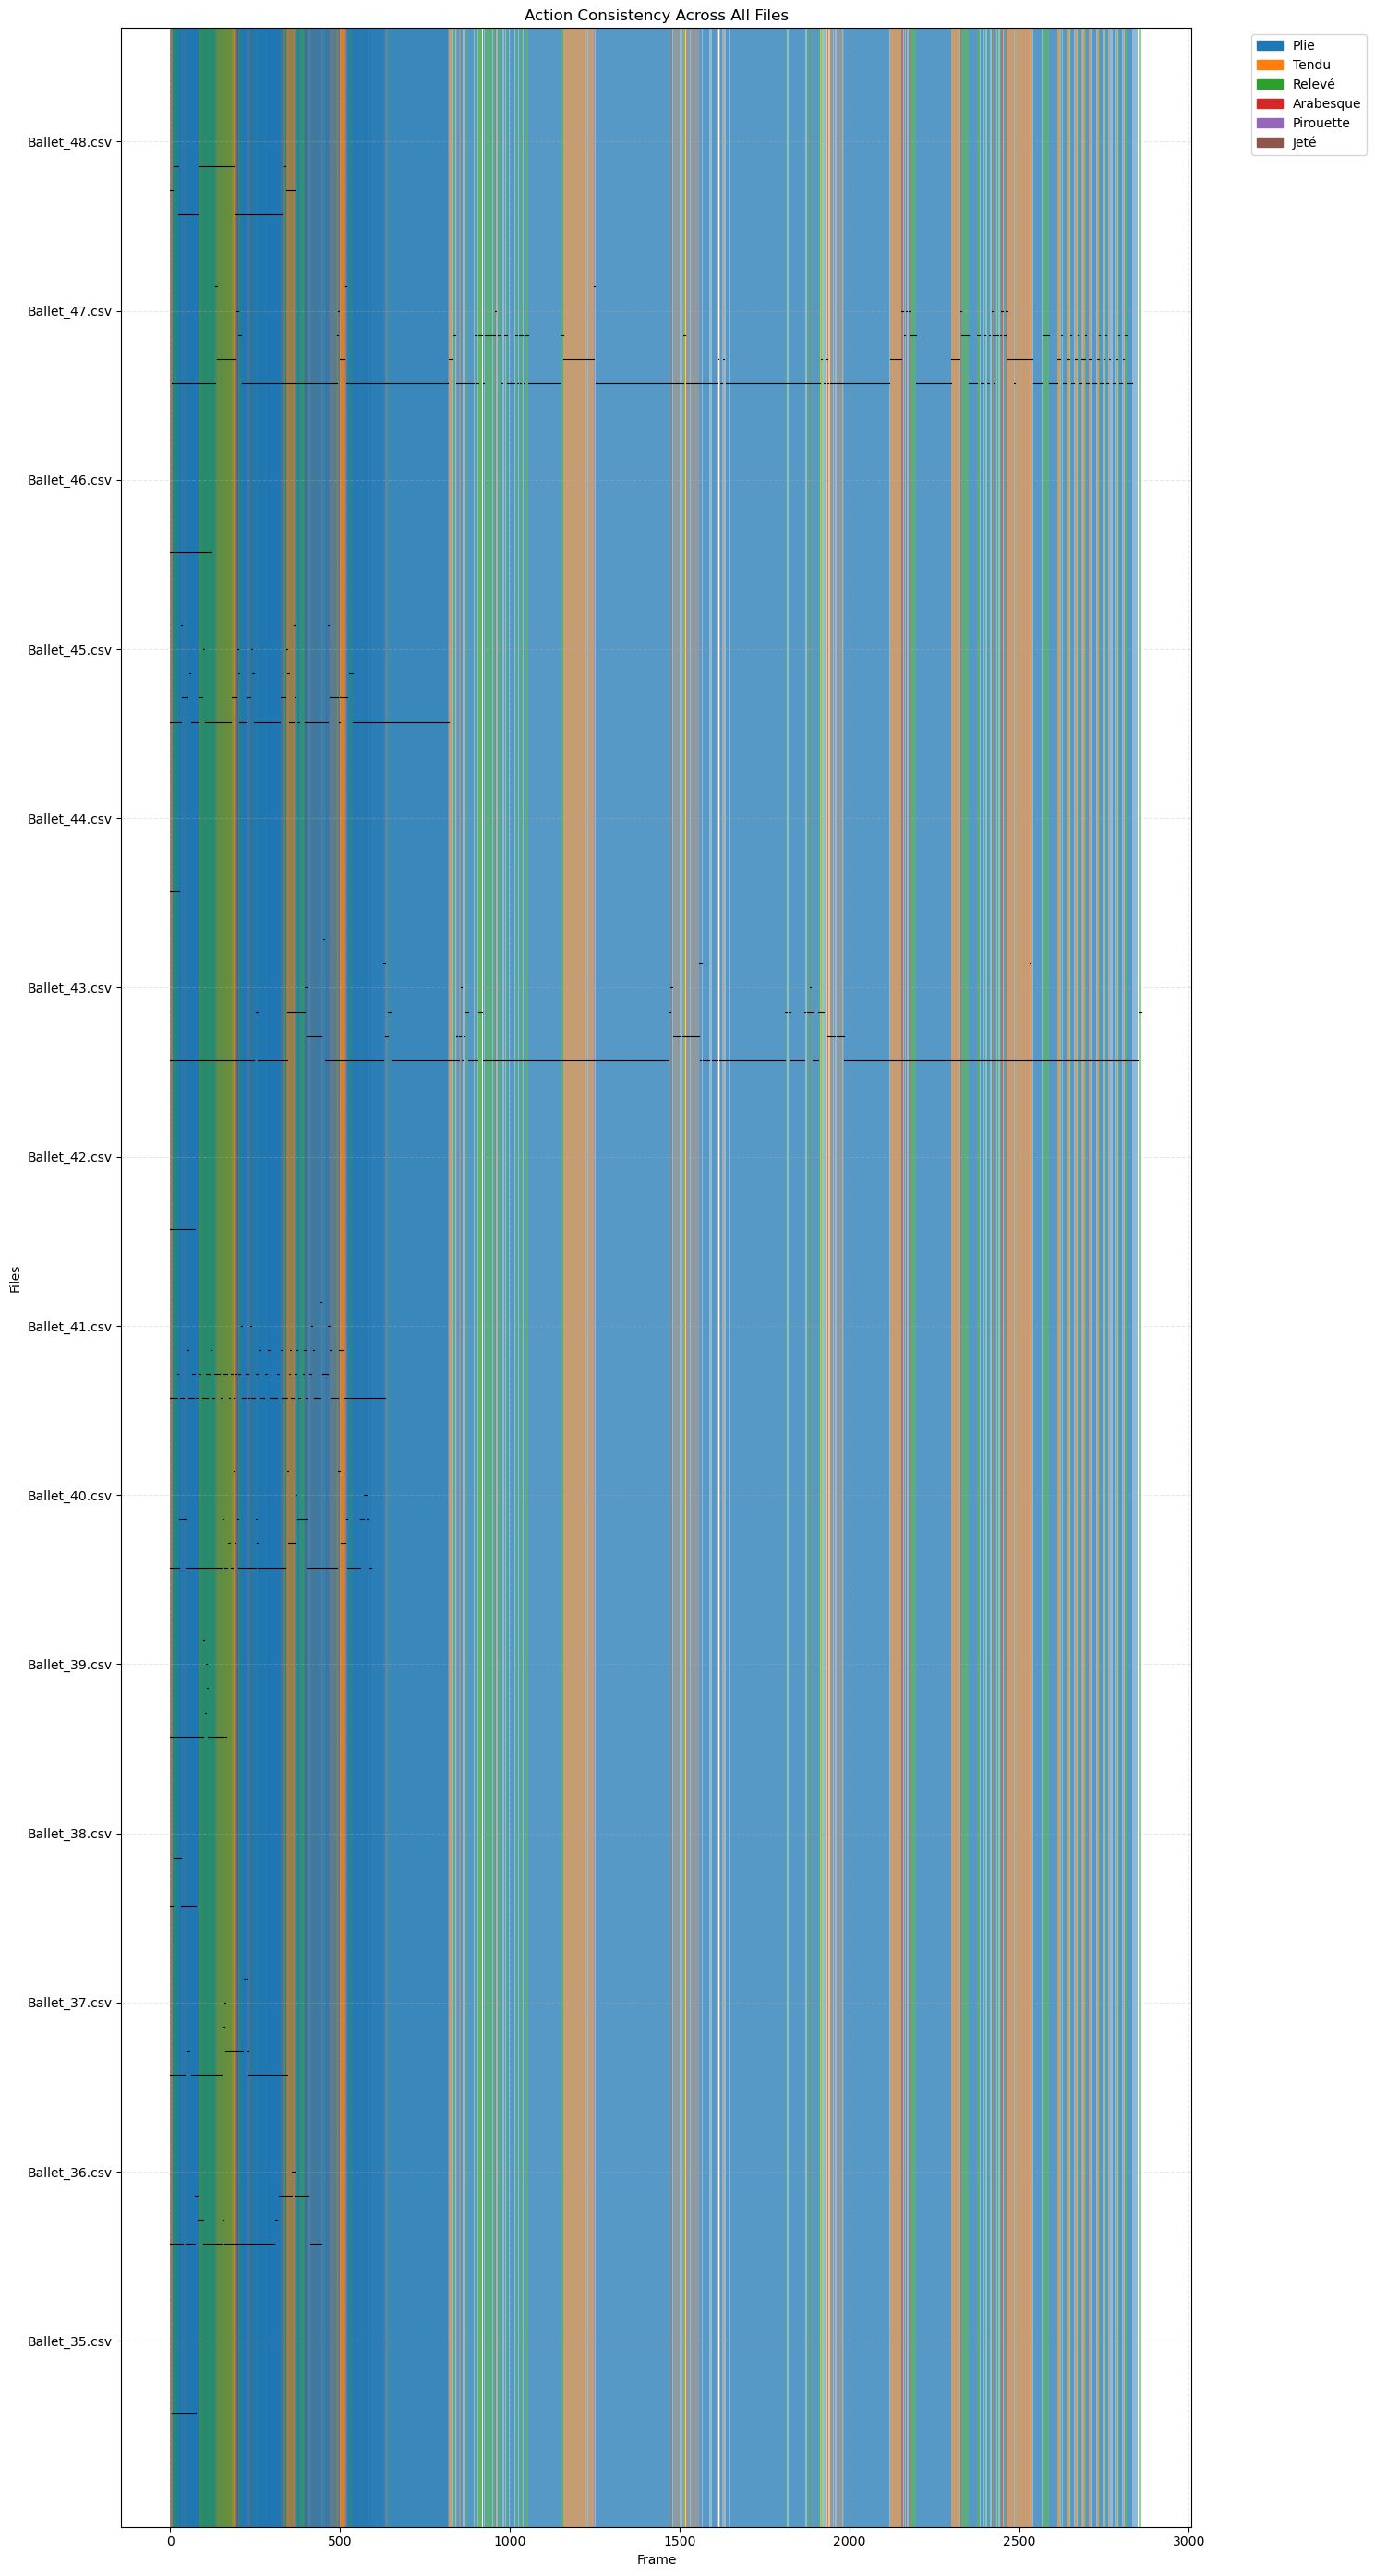

In [15]:
# -----------------------------
# step13. 整合所有檔案比較 cluster 一致性
# -----------------------------
plt.figure(figsize=(15, len(pose_data_dict)*2))

# 顏色對應 cluster
colors = plt.cm.tab10.colors  # 最多 10 種 cluster
yticks = []
yticklabels = []

for i, (file_name, compressed) in enumerate(compressed_pose_data.items()):
    offset = i * (NUM_ACTIONS + 1)  # 每個檔案上下偏移，避免重疊
    yticks.append(offset + NUM_ACTIONS / 2)
    yticklabels.append(file_name)
    
    for segment in compressed:
        label, start, end = segment
        plt.axvspan(start, end, facecolor=colors[label % 10], alpha=0.5)
        plt.plot(range(start, end+1), [offset+label]*(end-start+1), color='black', linewidth=0.8)

plt.xlabel("Frame")
plt.ylabel("Files")
plt.yticks(yticks, yticklabels)
plt.title("Action Consistency Across All Files")
plt.grid(True, linestyle='--', alpha=0.3)

# 圖例（動作名稱）
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=colors[i % 10], label=cluster_action_map[i]) for i in range(NUM_ACTIONS)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [16]:
# -----------------------------
# step14. 統計每個 cluster 在不同檔案的出現資訊
# -----------------------------
cluster_stats = []

for file_name, compressed in compressed_pose_data.items():
    total_frames = sum([seg[2]-seg[1]+1 for seg in compressed])
    cluster_counts = {}
    cluster_lengths = {}
    
    for seg in compressed:
        label, start, end = seg
        length = end - start + 1
        cluster_counts[label] = cluster_counts.get(label, 0) + length
        cluster_lengths[label] = cluster_lengths.get(label, []) + [length]
    
    for label in range(NUM_ACTIONS):
        count = cluster_counts.get(label, 0)
        ratio = count / total_frames if total_frames > 0 else 0
        avg_length = np.mean(cluster_lengths.get(label, [0]))
        cluster_stats.append({
            "File": file_name,
            "Cluster": label,
            "TotalFrames": count,
            "Ratio": ratio,
            "AvgSegmentLength": avg_length
        })

# 轉成 DataFrame
df_stats = pd.DataFrame(cluster_stats)

# 顯示表格
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(df_stats)

# -----------------------------
# 存成 CSV
# -----------------------------
df_stats.to_csv("ballet_cluster_stats.csv", index=False)
print("💾 Cluster 統計已存成 ballet_cluster_stats.csv")

             File  Cluster  TotalFrames  Ratio  AvgSegmentLength
0   Ballet_35.csv        0           76   0.97             25.33
1   Ballet_35.csv        1            0   0.00              0.00
2   Ballet_35.csv        2            1   0.01              1.00
3   Ballet_35.csv        3            1   0.01              1.00
4   Ballet_35.csv        4            0   0.00              0.00
..            ...      ...          ...    ...               ...
79  Ballet_48.csv        1           34   0.09             17.00
80  Ballet_48.csv        2          127   0.35             18.14
81  Ballet_48.csv        3            2   0.01              1.00
82  Ballet_48.csv        4            0   0.00              0.00
83  Ballet_48.csv        5            0   0.00              0.00

[84 rows x 5 columns]
💾 Cluster 統計已存成 ballet_cluster_stats.csv


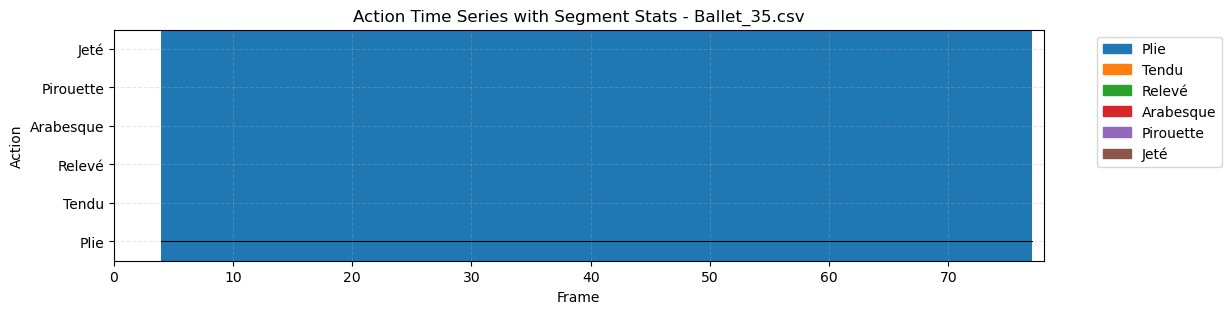

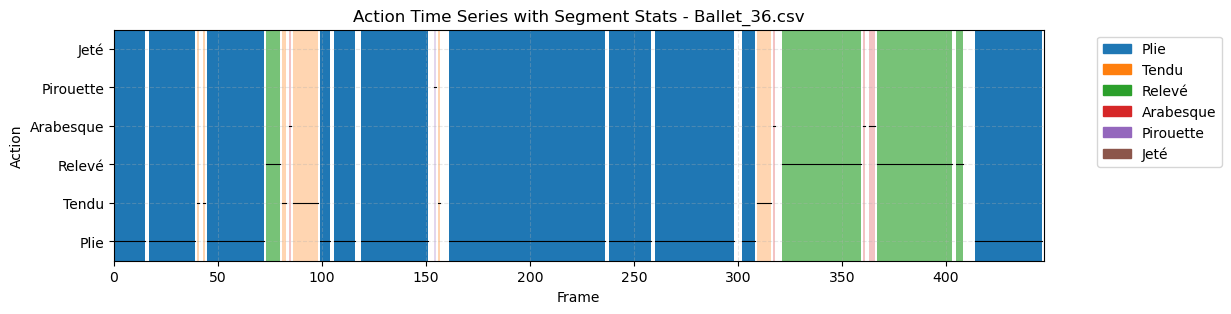

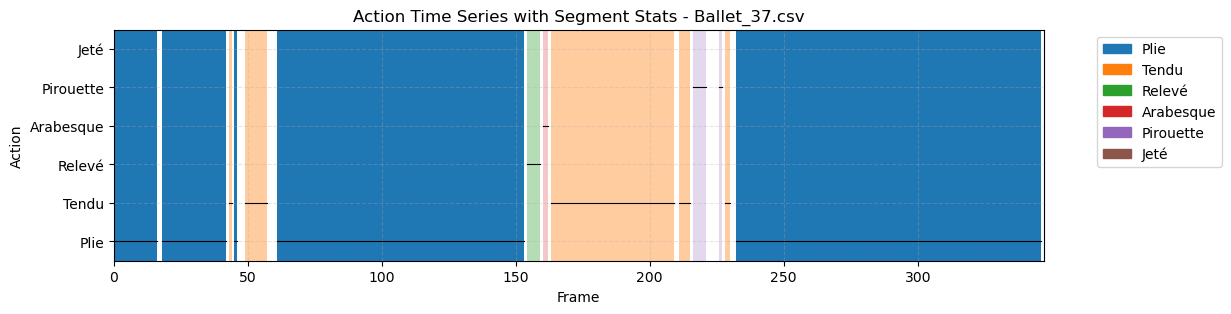

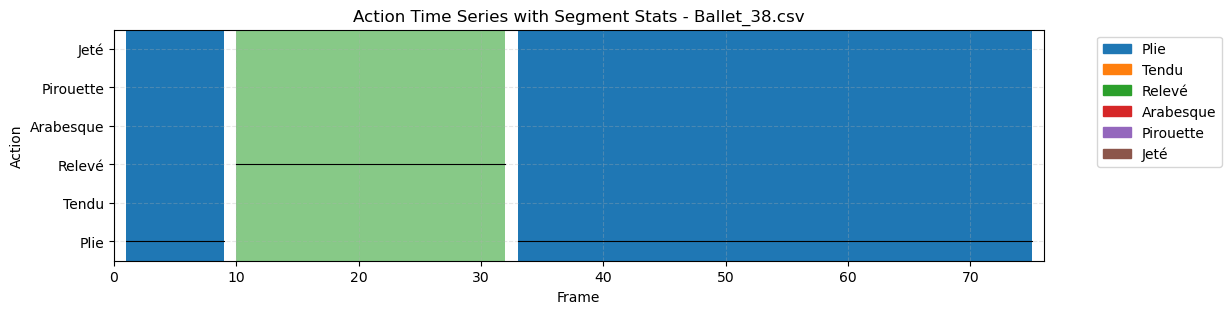

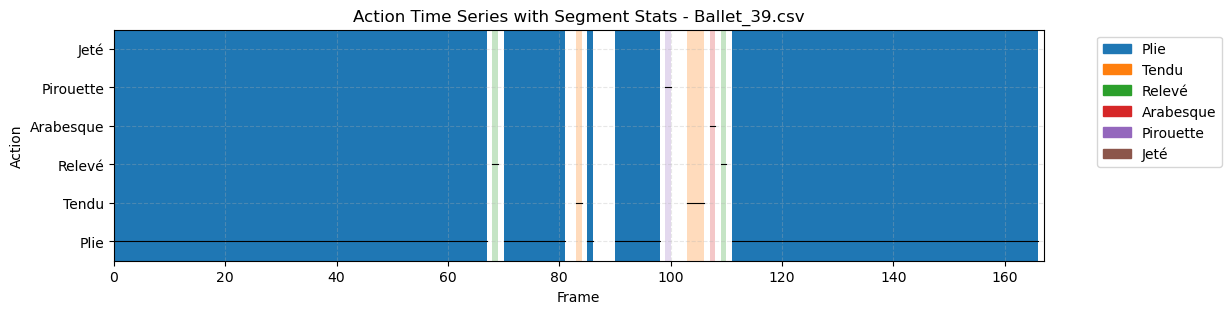

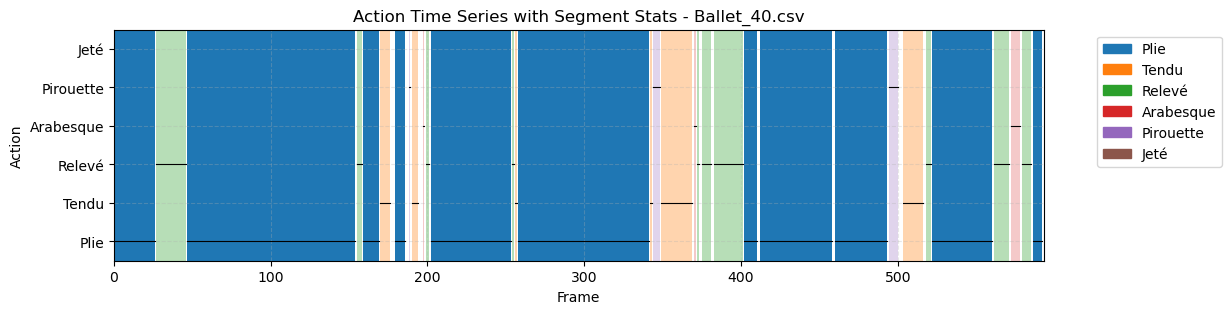

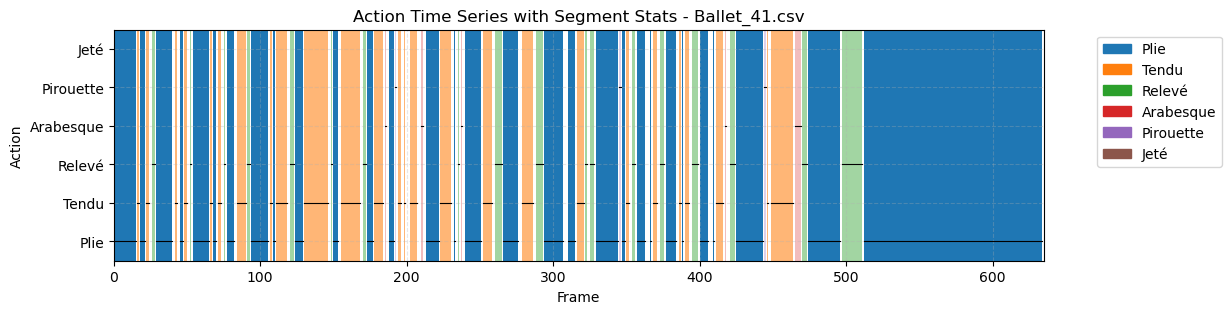

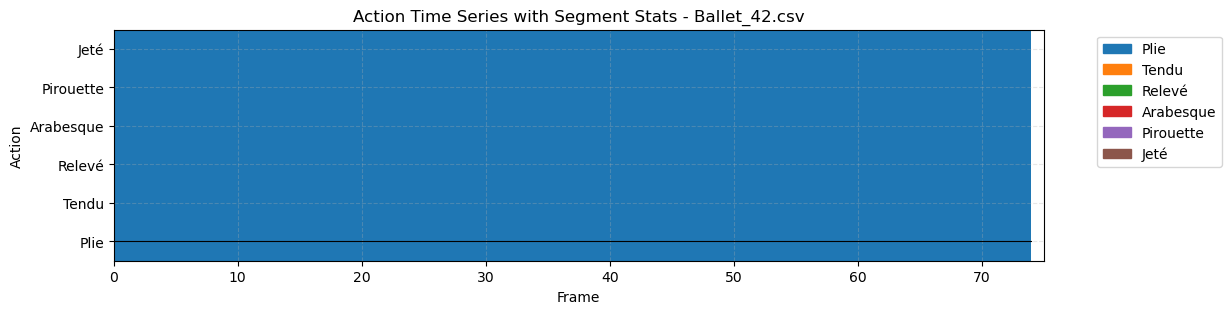

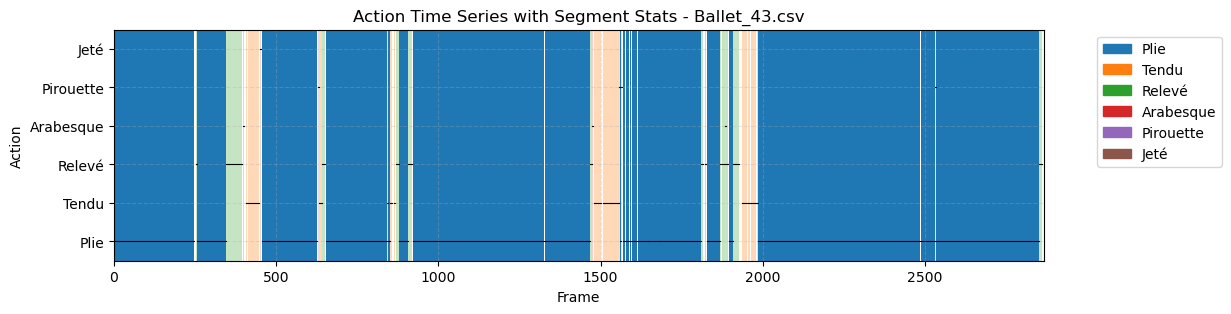

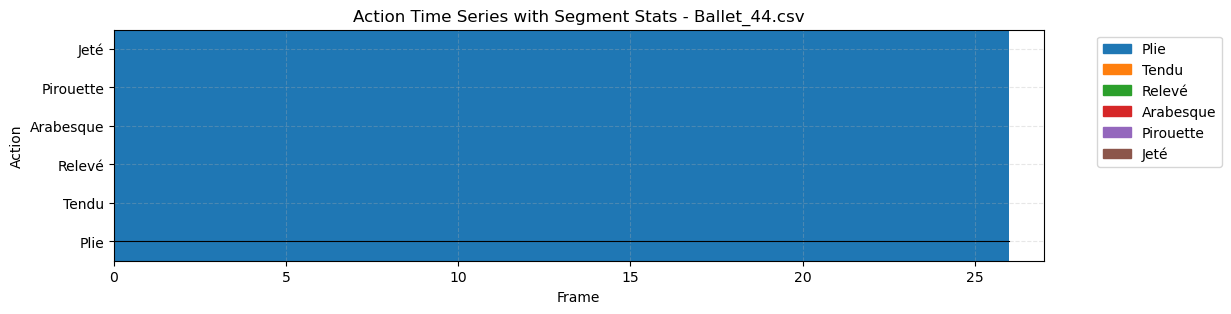

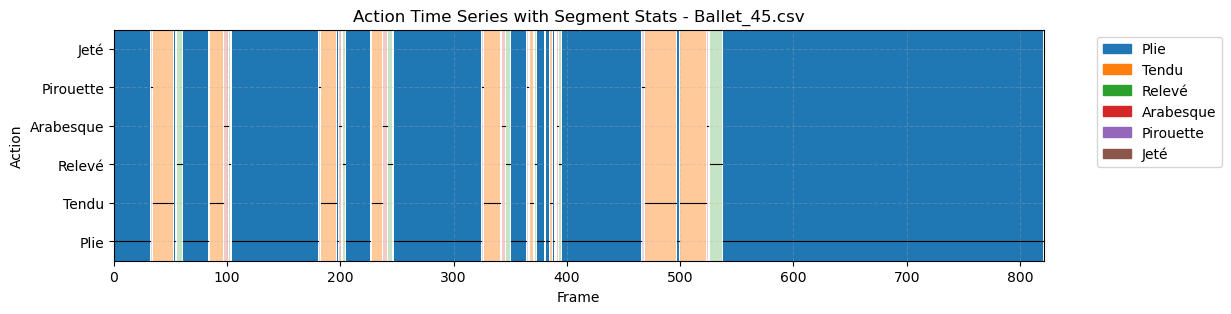

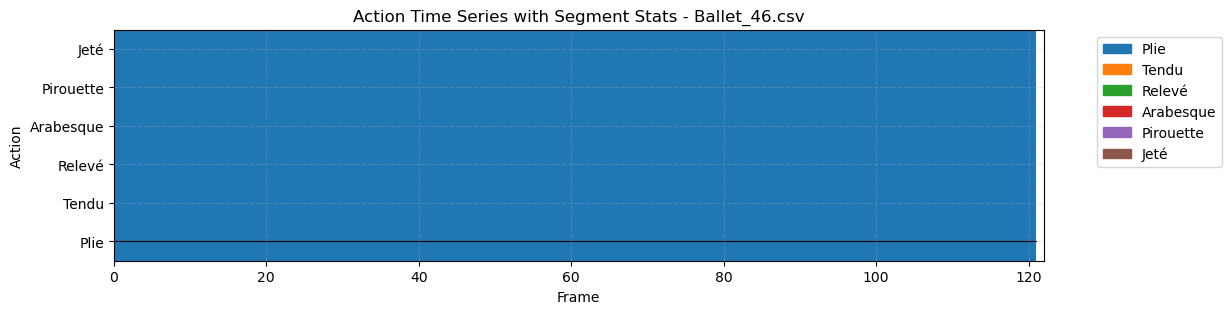

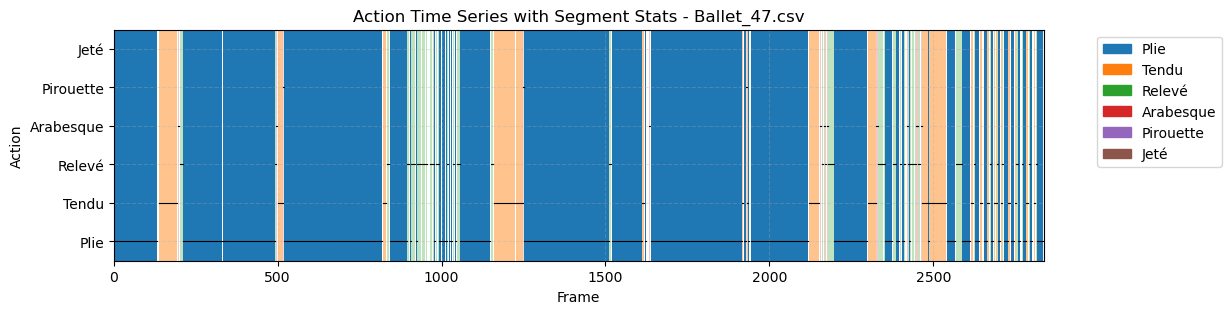

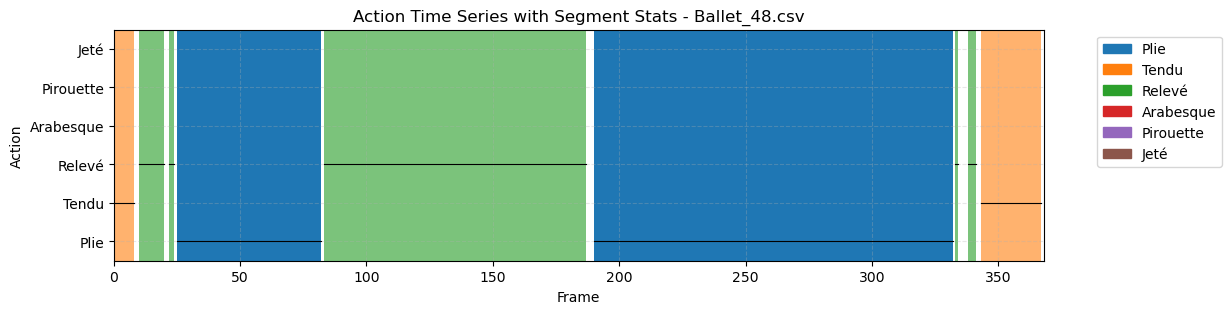

In [17]:
# -----------------------------
# step15. 結合統計資訊與時間序列圖
# -----------------------------
for file_name, compressed in compressed_pose_data.items():
    # 取得統計數據
    stats_file = df_stats[df_stats["File"] == file_name].set_index("Cluster")
    plt.figure(figsize=(12, 3))
    ax = plt.gca()
    
    # 顏色對應 cluster，顏色深淺對應平均段長
    max_length = stats_file["AvgSegmentLength"].max() if stats_file["AvgSegmentLength"].max() > 0 else 1
    colors = plt.cm.tab10.colors  # 10 種顏色
    for seg in compressed:
        label, start, end = seg
        alpha = stats_file.loc[label, "AvgSegmentLength"] / max_length * 0.8 + 0.2  # 透明度 0.2~1
        ax.axvspan(start, end, facecolor=colors[label % 10], alpha=alpha)
        ax.plot(range(start, end+1), [label]*(end-start+1), color='black', linewidth=0.8)
    
    ax.set_xlim(0, sum([seg[2]-seg[1]+1 for seg in compressed]))
    ax.set_ylim(-0.5, NUM_ACTIONS-0.5)
    ax.set_yticks(range(NUM_ACTIONS))
    ax.set_yticklabels([cluster_action_map[i] for i in range(NUM_ACTIONS)])  # Y軸顯示動作名稱
    ax.set_xlabel("Frame")
    ax.set_ylabel("Action")
    ax.set_title(f"Action Time Series with Segment Stats - {file_name}")
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # 圖例（使用動作名稱）
    import matplotlib.patches as mpatches
    patches = [mpatches.Patch(color=colors[i % 10], label=cluster_action_map[i]) for i in range(NUM_ACTIONS)]
    ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()